In [2]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import warnings
import seaborn as sns
import pandas_profiling
from shapely.geometry import Point
import folium
import datetime
from dateutil import relativedelta
import matplotlib.cm as cm
from datetime import datetime

# Preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# model
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

# yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Pipeline
from sklearn.pipeline import Pipeline

# GridSearch and cross-validation
from sklearn.model_selection import GridSearchCV

pd.set_option('max_columns', None)
%matplotlib inline
# pycodestyle_magic
%load_ext pycodestyle_magic
%flake8_on
# figures style
sns.set_style("whitegrid")

1: E999 SyntaxError: invalid syntax


# Clustering modelling

In [3]:
data = pd.read_csv('data_segmentation.csv')

# RFM anaylisis
A RFM analysis will be performed for the period of 19 months

In [4]:
from datetime import date
# dropping orders with price == 0
data = data[(data.price != 0) &
            (data.price.notnull())]

# working with date
data.order_purchase_timestamp = pd.to_datetime(data.
                                               order_purchase_timestamp).\
                                    dt.date


# selecting data between 01/2017 and 08/2018
# start_date = date(int(2017), int(1), int(1))
start_date = data.order_purchase_timestamp.min()
end_date = data.order_purchase_timestamp.max()
# end_date = date(int(2018), int(8), int(31))
period = (end_date - start_date).days

print('period of study:', period)
print(data.shape)
data = data[(data.order_purchase_timestamp >= start_date) &
            (data.order_purchase_timestamp <= end_date)]
data = data.reset_index(drop=True)
data.head()

period of study: 729
(98666, 15)


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

           customer_city  geolocation_lat  geolocation_lng  \
0                 franca       -20.534057       -47.398437   
1  sao bernardo do campo       -23.707626       -46.563869   
2              sao paulo       -23.570860       -46.633242   
3        mogi das cruzes       -23.530402       -46.193888   
4               campinas       -22.900861       -47.068536   

                           order_id order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1               2017-05-16   
1  29150127e6685892b6eab3eec79f59c7               2018-01-12   
2  b2059ed67ce144a36e2aa97d2c9e9ad2               2018-05-19   
3  951670f92359f4fe4a63112aa7306eba               2018-03-13   
4  6b7d50bd145f6fc7f33cebabd7e49d0f               2018-07-29   

  order_delivered_customer_date  review_score  payment_value  n_items   price  \
0           2017-05-25 10:35:35           4.0         146.87      1.0  124.99   
1           2018-01-29 12:41:19           5.0         335.48      1.0  289.00   
2           2018-06-14 17:58:51           5.0         157.73      1.0  139.94   
3           2018-03-28 16:04:25           5.0         173.30      1.0  149.94   
4           2018-08-09 20:55:48           5.0         252.25      1.0  230.00   

   freight_value      product_category  n_product_category  
0          21.88  ['office_furniture']                 1.0  
1          46.48        ['housewares']                 1.0  
2          17.79  ['office_furniture']                 1.0  
3          23.36  ['office_furniture']                 1.0  
4          22.25      ['home_confort']                 1.0

In [5]:
# New features for RFM analysis
# Quantity of purchases
# Rencency
data['n_purchase'] = 1
data['recency'] = (end_date - data.order_purchase_timestamp)
data['recency'] = data.recency.dt.days


In [6]:
# Dataframe for rfm_analysis
rfm = data[['customer_unique_id', 'n_purchase', 'recency', 'price']]
rfm = rfm.groupby('customer_unique_id').agg({
                                             'n_purchase': 'sum',
                                             'recency': 'min',
                                             'price': 'sum'})
rfm = rfm.reset_index()
rfm = rfm.rename(columns={'n_purchase': 'frequency', 'price': 'monetary'})
rfm

customer_unique_id  frequency  recency  monetary
0      0000366f3b9a7992bf8c76cfdf3221e2          1      116    129.90
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1      119     18.90
2      0000f46a3911fa3c0805444483337064          1      542     69.00
3      0000f6ccb0745a6a4b88665a16c9f078          1      326     25.99
4      0004aac84e0df4da2b147fca70cf8255          1      293    180.00
...                                 ...        ...      ...       ...
95415  fffcf5a5ff07b0908bd4e2dbc735a684          1      452   1570.00
95416  fffea47cd6d3cc0a88bd621562a9d061          1      267     64.89
95417  ffff371b4d645b6ecea244b27531430a          1      573     89.90
95418  ffff5962728ec6157033ef9805bacc48          1      124    115.00
95419  ffffd2657e2aad2907e67c3e9daecbeb          1      489     56.99

[95420 rows x 4 columns]

In [7]:
rfm.describe()

frequency       recency      monetary
count  95420.000000  95420.000000  95420.000000
mean       1.034018    243.501457    142.440198
std        0.211234    153.160850    217.656355
min        1.000000      0.000000      0.850000
25%        1.000000    119.000000     47.900000
50%        1.000000    224.000000     89.900000
75%        1.000000    353.000000    155.000000
max       16.000000    729.000000  13440.000000

In [8]:
# sns.displot(rfm.recency)
# sns.displot(rfm.frequency)
# sns.displot(rfm.monetary)

In [9]:
# Calculate R and F groups
# create lables for recency and frequency
r_labels = range(4, 0, -1)
f_labels = range(1, 5)

# assign labels for recency
r_group = pd.qcut(rfm.recency, q=4, labels=r_labels)
# assign labels for freqency


def f_labels(x):
    if x > 1:
        return 5
    else:
        return 1


f_group = rfm.frequency.apply(lambda x: f_labels(x))

# assign labels for recency
m_labels = range(1, 5)
m_group = pd.qcut(rfm.monetary, q=4, labels=m_labels)

# create new columns
rfm = rfm.assign(R=r_group.values, F=f_group, M=m_group)
rfm.head()

customer_unique_id  frequency  recency  monetary  R  F  M
0  0000366f3b9a7992bf8c76cfdf3221e2          1      116    129.90  4  1  3
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1      119     18.90  4  1  1
2  0000f46a3911fa3c0805444483337064          1      542     69.00  1  1  2
3  0000f6ccb0745a6a4b88665a16c9f078          1      326     25.99  2  1  1
4  0004aac84e0df4da2b147fca70cf8255          1      293    180.00  2  1  4

In [10]:
# Concat r-f-m to create RFM segments
def join_rfm(x):
    return str(x['R'])+str(x['F'])+str(x['M'])


rfm['RFM_segment'] = rfm.apply(join_rfm, axis=1)
rfm

customer_unique_id  frequency  recency  monetary  R  F  \
0      0000366f3b9a7992bf8c76cfdf3221e2          1      116    129.90  4  1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1      119     18.90  4  1   
2      0000f46a3911fa3c0805444483337064          1      542     69.00  1  1   
3      0000f6ccb0745a6a4b88665a16c9f078          1      326     25.99  2  1   
4      0004aac84e0df4da2b147fca70cf8255          1      293    180.00  2  1   
...                                 ...        ...      ...       ... .. ..   
95415  fffcf5a5ff07b0908bd4e2dbc735a684          1      452   1570.00  1  1   
95416  fffea47cd6d3cc0a88bd621562a9d061          1      267     64.89  2  1   
95417  ffff371b4d645b6ecea244b27531430a          1      573     89.90  1  1   
95418  ffff5962728ec6157033ef9805bacc48          1      124    115.00  3  1   
95419  ffffd2657e2aad2907e67c3e9daecbeb          1      489     56.99  1  1   

       M RFM_segment  
0      3         413  
1      1         411  
2      2         112  
3      1         211  
4      4         214  
...   ..         ...  
95415  4         114  
95416  2         212  
95417  2         112  
95418  3         313  
95419  2         112  

[95420 rows x 8 columns]

In [11]:
# number of unique clients
number_of_clients = rfm.groupby('RFM_segment')['RFM_segment'].\
                    nunique().sum()
print('there are', number_of_clients,
      'types of clients')

# Calculatinf RFM score for customers
rfm['RFM_score'] = rfm[['R', 'F', 'M']].sum(axis=1)
rfm.head()

there are 32 types of clients


customer_unique_id  frequency  recency  monetary  R  F  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1      116    129.90  4  1  3   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1      119     18.90  4  1  1   
2  0000f46a3911fa3c0805444483337064          1      542     69.00  1  1  2   
3  0000f6ccb0745a6a4b88665a16c9f078          1      326     25.99  2  1  1   
4  0004aac84e0df4da2b147fca70cf8255          1      293    180.00  2  1  4   

  RFM_segment  RFM_score  
0         413          8  
1         411          6  
2         112          4  
3         211          4  
4         214          7

In [12]:
# plot distribution of RFM segment
# fig11 = sns.displot(rfm.RFM_segment.sort_values(), aspect=15/5)

In [13]:
# fig10 = sns.countplot(data=rfm, x='RFM_score', dodge=False)
# fig10.set_title('RFM score distribution')

In [14]:
# description of scores
rfm.RFM_score.describe()

count    95420.000000
mean         6.111612
std          1.802548
min          3.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         13.000000
Name: RFM_score, dtype: float64

In [15]:
# labels for customers
c_labels = ['need attention', 'potential', 'best customers']
cuts = [0, 0.25, 0.75, 1]
rfm['RFM_level'] = pd.qcut(rfm.RFM_score, cuts, labels=c_labels)
rfm.head()

customer_unique_id  frequency  recency  monetary  R  F  M  \
0  0000366f3b9a7992bf8c76cfdf3221e2          1      116    129.90  4  1  3   
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1      119     18.90  4  1  1   
2  0000f46a3911fa3c0805444483337064          1      542     69.00  1  1  2   
3  0000f6ccb0745a6a4b88665a16c9f078          1      326     25.99  2  1  1   
4  0004aac84e0df4da2b147fca70cf8255          1      293    180.00  2  1  4   

  RFM_segment  RFM_score       RFM_level  
0         413          8  best customers  
1         411          6       potential  
2         112          4  need attention  
3         211          4  need attention  
4         214          7       potential

In [16]:
# fig9 = sns.countplot(data=rfm, x='RFM_level', dodge=False)
# fig9.set_title('Distribution of type of consumers from RFM')

In [17]:
# px.scatter(rfm, x='frequency', y='monetary', color='RFM_level', size='recency')

1:80: E501 line too long (81 > 79 characters)
1:80: E501 line too long (81 > 79 characters)
1:80: E501 line too long (81 > 79 characters)


In [18]:
#fig8 = sns.barplot(data=rfm, x='RFM_level', y='monetary')
#fig8.set_title('Money spend by each customer class')

1:1: E265 block comment should start with '# '
2:1: E265 block comment should start with '# '


In [19]:
# Count customers
rfm_level_count = rfm.groupby('RFM_level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)
rfm_level_count

recency frequency monetary       
                  mean      mean     mean  count
RFM_level                                       
need attention   350.2       1.0     55.3  35731
potential        210.3       1.0    156.4  40104
best customers   117.0       1.2    272.9  19585

In [20]:
# treeplot
rfm_level_count.columns = rfm_level_count.columns.droplevel()
rfm_level_count.columns = ['RecencyMean', 'FrequencyMean',
                           'MonetaryMean', 'Count']
rfm_level_count

RecencyMean  FrequencyMean  MonetaryMean  Count
RFM_level                                                      
need attention        350.2            1.0          55.3  35731
potential             210.3            1.0         156.4  40104
best customers        117.0            1.2         272.9  19585

Text(0.5, 1.0, 'RFM Segments')

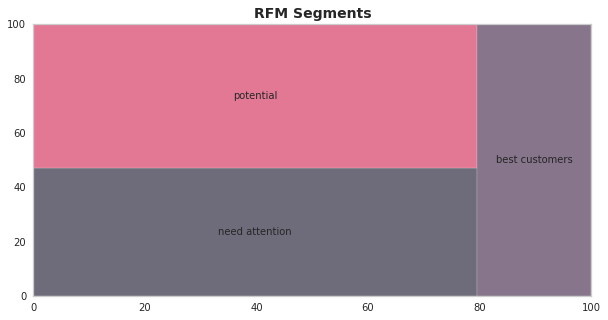

9:1: E265 block comment should start with '# '


In [21]:
import squarify
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(10, 5)
plt.grid(False)
squarify.plot(sizes=rfm_level_count['Count'], label=c_labels, alpha=0.6)
plt.title("RFM Segments", fontsize=14, fontweight="bold")
# plt.axis('off')
#plt.show()

## Conclusions
The recency, frequency and monetary of each customer has been calculated. The RFM_segmentation of the data set shows 62 types of customers, in order to summarize this the RFM score was calculated additioning the R-F-M value.
The RFM_score was used to determine 3 types of customers, the quantiles Q1 and Q3 were used:
- Need attention: [min, Q1);
- Potential: [Q1, Q3);
- Best customers: [Q3, max]

40% of the customers needs attention and 40% are potential customers.

# Unsupervised machine learning algorithms
Using DBSCAN and K-means to cluster customers

# Baseline model K-mean
This first model will used as features de R-F-M features.

In [22]:
data_bm = pd.DataFrame(rfm[['recency', 'frequency', 'monetary']])
#sns.heatmap(data_bm.corr(), cmap='YlGnBu', annot=True)

2:1: E265 block comment should start with '# '


In [23]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
# Preprocessing
X = data_bm[['recency', 'frequency', 'monetary']]

preprocessor = ColumnTransformer(transformers=[
                                               ('scaler', StandardScaler(),
                                                ['recency',
                                                 'frequency',
                                                 'monetary'])])

X_trans = pd.DataFrame(preprocessor.fit_transform(X), columns=X.columns)

In [24]:
print(X.shape)
#sns.boxplot(data=(X_trans))

2:1: E265 block comment should start with '# '


(95420, 3)


In [25]:
q1 = X.monetary.quantile(q=0.25)
q3 = X.monetary.quantile(q=0.75)
IQR = q3 - q1
X2 = X[X.monetary < (q3 + 1.5*IQR)]
X2trans = pd.DataFrame(preprocessor.fit_transform(X2))
print(X2.shape)
#sns.boxplot(data=(X2trans))

7:1: E265 block comment should start with '# '


(87408, 3)


### Elbow method

In [26]:
# find K value for K_mean model
# elbow method

def elbow_method(k_min, k_max, data_trans):
    elbow = []
    K = range(k_min, k_max)
    for k in K:
        model = KMeans(n_clusters=k, random_state=40, init='k-means++')
        clf = model.fit(data_trans)
        inertia = clf.inertia_
        elbow.append(inertia)

    results = pd.DataFrame({'k': K, 'Inertia': elbow})

    return results

In [27]:
# running elbow method for baseline model
bl_elbow = elbow_method(1, 10, X_trans)

In [28]:
fig1 = px.line(bl_elbow, x='k', y='Inertia',
               title='Elbow Method showing the optimal number of clusters',
               labels={'x': 'Number of clusters', 'y': 'Inertie'},
               width=800, height=600)
fig1.update_traces(mode='markers+lines')

**The elbow method allow us to determine the most suitable number of clusters, in this case k=4.**
### Silhouette score

In [29]:
def sil_score(k_min, k_max, data_trans):
    sc = []
    K = range(k_min, k_max)
    for k in K:
        model = KMeans(n_clusters=k, random_state=40,
                       init='k-means++')
        labels = model.fit_predict(data_trans)
        score = silhouette_score(data_trans, labels)
        print('k:', k, 'score:', score)
        sc.append(score)

    results = pd.DataFrame({'k': K, 'sil_scores': sc})

    return results

In [30]:
# scores = sil_score(2, 6, X_trans)

px.line(scores, x='k', y='sil_scores')

## Implementing K-mean clustering
- pre-processing : StandardScaler()
- k = 4,
- init = 'k-mean++'

In [31]:
# dataframe to summarize information
# from models
models_info = pd.DataFrame(columns=['model',
                                    'n_clusters',
                                    'score',
                                    'inertia',
                                    'time'])

In [32]:
# Creating model for 4 clusters
start = datetime.now()

# model
k = 4
model = KMeans(n_clusters=k, random_state=40,
               init='k-means++')

# fit, labels and inertia
clf = model.fit(X_trans)
labels = model.fit_predict(X_trans)
score = silhouette_score(X_trans, labels)
inertia = clf.inertia_

end = datetime.now()
time = end - start

In [33]:
models_info = models_info.append({'model': 'rfm_kmean',
                                  'n_clusters': k,
                                  'score': score,
                                  'inertia': inertia,
                                  'time': time.total_seconds()},
                                 ignore_index=True)
models_info

model n_clusters     score       inertia        time
0  rfm_kmean          4  0.490767  94311.470967  129.885026

In [34]:
# preparing dataframe with labels
base_kmean = pd.DataFrame(rfm[['customer_unique_id',
                               'frequency', 'recency',
                               'monetary']])
base_kmean['label'] = labels

## Exploring results

In [35]:
# Fonction to plot the silhouette diagramme


def silhouette_diagram(k, model):
    K = [k]
    for k in K:
        fig, ax1 = plt.subplots()
        fig.set_size_inches(18, 7)
        # set lim on y_axis
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        ax1.set_ylim([0, len(X_trans) + (k + 1)*10])

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        cluster_labels = model.fit_predict(X_trans)
        # Silhouette average score
        silhouette_avg = silhouette_score(X_trans, cluster_labels)

        print('average score for k =', k, ' is ', silhouette_avg)

        # Silhouette score for each sample
        sample_silhouette_val = silhouette_samples(X_trans, cluster_labels)

        y_lower = 10

        for i in range(k):
            # The (n_clusters+1)*10 is for inserting blank
            # space between silhouette
            cluster_silhouette_values = sample_silhouette_val[
                                        cluster_labels == i]

            cluster_silhouette_values.sort()

            size_cluster_i = cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / k)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster
            # numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

In [36]:
#silhouette_diagram(k, model)

1:1: E265 block comment should start with '# '


In [37]:
#base_kmean[base_kmean.label==0].describe()

1:1: E265 block comment should start with '# '


<AxesSubplot:xlabel='label', ylabel='recency'>

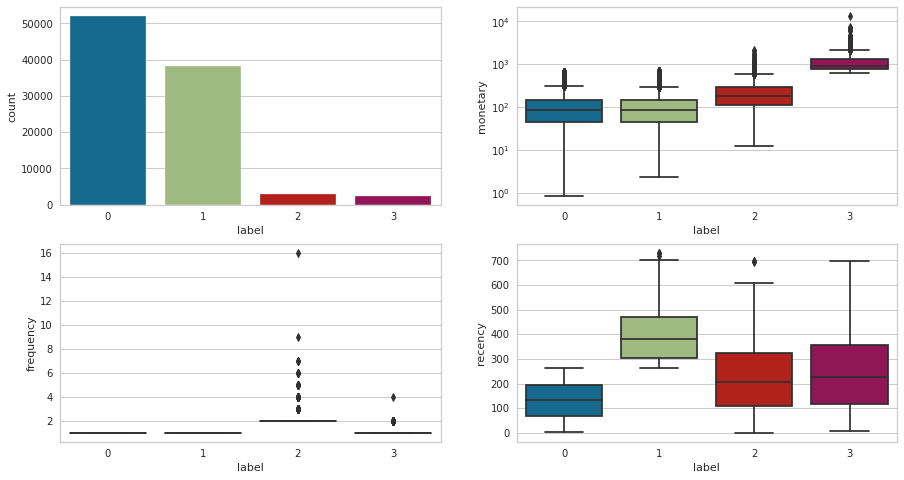

In [38]:
fig3, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.countplot(ax=ax[0, 0], data=base_kmean, x='label')
sns.boxplot(ax=ax[0, 1], data=base_kmean, x='label', y='monetary')
ax[0, 1].set(yscale='log')
sns.boxplot(ax=ax[1, 0], data=base_kmean, x='label', y='frequency')
sns.boxplot(ax=ax[1, 1], data=base_kmean, x='label', y='recency')

In [39]:
fig = px.parallel_coordinates(base_kmean, color='label',
                              dimensions=['frequency',
                                          'recency',
                                          'monetary'],
                              color_continuous_scale=px.colors.
                              diverging.Tealrose,
                              color_continuous_midpoint=2)
# fig.show()

# DBSCAN
Density-based algorithm. Defines clusters as dense regions of space separated by low-density.
Parameters:
- Epsilon: radius of  the area around the point defining the maximum distance between such point and any other points in the neighborhood of the other.
- min points: minimum number of points present in the neighborhood required to form a cluster

In [45]:
# Data selection
X_dbscan = pd.DataFrame(rfm[['recency', 'monetary', 'frequency']])
X_min = X_dbscan.sample(20000)
# Data transformation
scaler = StandardScaler()
X_tdbscan = pd.DataFrame(scaler.fit_transform(X_min),
                         columns=X_dbscan.columns)
X_tdbscan

recency  monetary  frequency
0      0.591599 -0.493824  -0.166227
1     -0.586380 -0.633803  -0.166227
2     -0.664912  1.153370  -0.166227
3      1.265665  0.141165  -0.166227
4      0.270927 -0.568851  -0.166227
...         ...       ...        ...
19995 -1.352066 -0.617286  -0.166227
19996 -1.325889 -0.605226  -0.166227
19997  1.645236 -0.498135  -0.166227
19998 -1.378243  0.068076  -0.166227
19999  0.231661 -0.318923  -0.166227

[20000 rows x 3 columns]

In [46]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# calculate the distance from each point
# to its closest neighbour

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_tdbscan)
distances, indices = nbrs.kneighbors(X_tdbscan)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

distances
px.line(distances)

5:41: W291 trailing whitespace


In [72]:
eps = np.round(np.arange(0.15, 0.85, 0.05), 2)
min_samples = 100
S = []
comb = []
for k in eps:
    model = DBSCAN(eps=k, min_samples=min_samples)
    clm = model.fit(X_tdbscan)
    S.append(silhouette_score(X_tdbscan, clm.labels_))
    comb.append(str(k))

In [73]:
px.line(x=comb, y=S, labels={'y': 'score', 'x': 'epsilon'})

We will use, an epsilon value of 2.

In [74]:
# eps:max distance between two samples for one
# to be considered as in the neighborhood of the other.
# min_sample: The number of samples (or total weight)
# in a neighborhood for a point to be considered as a core point.
# metric ='euclidean'. The metric to use when calculating distance
# between instances in a feature array.
# algo = ’auto’, The algorithm to be used by the NearestNeighbors
# module to compute pointwise distances and find nearest neighbors.
eps_final = 0.8
m_dbscan = DBSCAN(eps=eps_final,
                  min_samples=min_samples,
                  metric='euclidean',
                  algorithm='auto')

clm_dbscan = m_dbscan.fit(X_tdbscan)

In [75]:
# getting labels
X_min['label'] = clm_dbscan.labels_
X_min

recency  monetary  frequency  label
13542      332     38.89          1      0
48964      152      9.99          1      0
50879      140    378.97          1      0
17243      435    169.99          1      0
93540      283     23.40          1      0
...        ...       ...        ...    ...
18701       35     13.40          1      0
73949       39     15.89          1      0
67829      493     38.00          1      0
71620       31    154.90          1      0
15596      277     75.00          1      0

[20000 rows x 4 columns]

<AxesSubplot:xlabel='label', ylabel='count'>

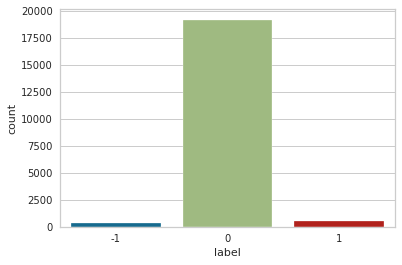

In [76]:
sns.countplot(data=X_min, x='label')

<AxesSubplot:xlabel='label', ylabel='recency'>

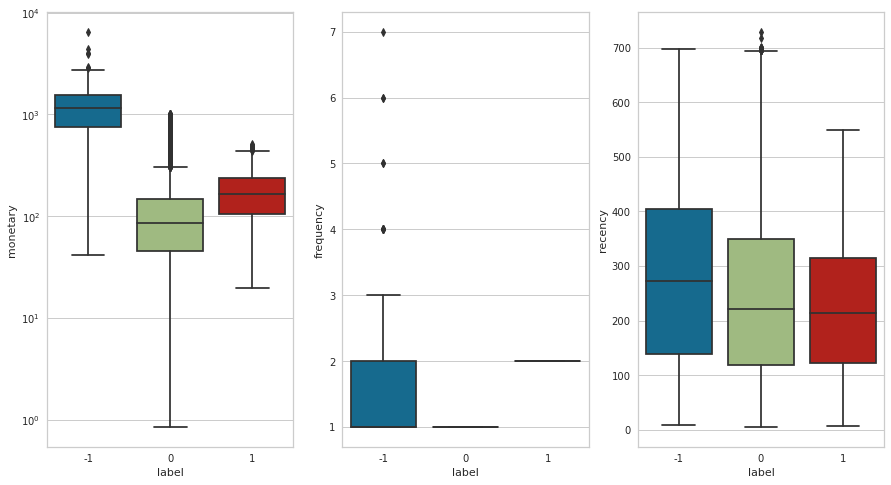

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
sns.boxplot(ax=ax[0], data=X_min, x='label', y='monetary')
ax[0].set(yscale='log')
sns.boxplot(ax=ax[1], data=X_min, x='label', y='frequency')
sns.boxplot(ax=ax[2], data=X_min, x='label', y='recency')

# K-Mean modele with review scores
## Selecting data

In [80]:
mean_review = pd.DataFrame(data[['customer_unique_id',
                                 'review_score',
                                 'n_purchase']])
mean_review = mean_review.groupby('customer_unique_id').\
              agg({'review_score': 'mean',
                   'n_purchase': 'sum'
                   }).reset_index()
mean_review = mean_review.rename(columns={'review_score': 'mean_rs'})

mean_review['mean_rs'] = mean_review.groupby('n_purchase')['mean_rs'].\
                         apply(lambda x: x.fillna(x.mean()))

mean_review.mean_rs = mean_review.mean_rs.round(2)
mean_review

customer_unique_id  mean_rs  n_purchase
0      0000366f3b9a7992bf8c76cfdf3221e2      5.0           1
1      0000b849f77a49e4a4ce2b2a4ca5be3f      4.0           1
2      0000f46a3911fa3c0805444483337064      3.0           1
3      0000f6ccb0745a6a4b88665a16c9f078      4.0           1
4      0004aac84e0df4da2b147fca70cf8255      5.0           1
...                                 ...      ...         ...
95415  fffcf5a5ff07b0908bd4e2dbc735a684      5.0           1
95416  fffea47cd6d3cc0a88bd621562a9d061      4.0           1
95417  ffff371b4d645b6ecea244b27531430a      5.0           1
95418  ffff5962728ec6157033ef9805bacc48      5.0           1
95419  ffffd2657e2aad2907e67c3e9daecbeb      5.0           1

[95420 rows x 3 columns]

In [81]:
#px.histogram(mean_review, x='mean_rs')

1:1: E265 block comment should start with '# '


In [82]:
#sns.boxplot(data=mean_review, x='mean_rs')

1:1: E265 block comment should start with '# '


In [83]:
rfm_rs = pd.DataFrame(rfm[['customer_unique_id',
                           'recency',
                           'frequency',
                           'monetary']])
rfm_rs = pd.merge(rfm_rs, mean_review[['customer_unique_id', 'mean_rs']],
                  on='customer_unique_id', how='left')
#
rfm_rs

customer_unique_id  recency  frequency  monetary  mean_rs
0      0000366f3b9a7992bf8c76cfdf3221e2      116          1    129.90      5.0
1      0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     18.90      4.0
2      0000f46a3911fa3c0805444483337064      542          1     69.00      3.0
3      0000f6ccb0745a6a4b88665a16c9f078      326          1     25.99      4.0
4      0004aac84e0df4da2b147fca70cf8255      293          1    180.00      5.0
...                                 ...      ...        ...       ...      ...
95415  fffcf5a5ff07b0908bd4e2dbc735a684      452          1   1570.00      5.0
95416  fffea47cd6d3cc0a88bd621562a9d061      267          1     64.89      4.0
95417  ffff371b4d645b6ecea244b27531430a      573          1     89.90      5.0
95418  ffff5962728ec6157033ef9805bacc48      124          1    115.00      5.0
95419  ffffd2657e2aad2907e67c3e9daecbeb      489          1     56.99      5.0

[95420 rows x 5 columns]

In [84]:
#sns.heatmap(rfm_rs.corr(), cmap='YlGnBu', annot=True)

1:1: E265 block comment should start with '# '


## K-value: elbow and score method

In [85]:
# Data matrix
X = pd.DataFrame(rfm_rs[['recency', 'frequency', 'monetary', 'mean_rs']])
# scaler
scaler = StandardScaler()
# transform data
X_trans = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# describe
# X_trans.describe()

### Elbow method

In [86]:
rfm_rs_elbow = elbow_method(2, 10, X_trans)
fig2 = px.line(rfm_rs_elbow, x='k', y='Inertia',
               title='Elbow Method showing the optimal number of clusters',
               labels={'x': 'Number of clusters', 'y': 'Inertie'},
               width=800, height=600)
fig2.update_traces(mode='markers+lines')

### Score method

rfm_rs_score = sil_score(2, 7, X_trans)

rfm_rs_score

px.line(rfm_rs_score, x='k', y='sil_scores')

## Implemeting K-mean
- k=5
- scaler = StandardScaler

In [87]:
# Creating model for 5 clusters
start = datetime.now()

# model
k = 5
model = KMeans(n_clusters=k, random_state=40,
               init='k-means++')

# fit, labels and inertia
clf = model.fit(X_trans)
labels = model.fit_predict(X_trans)
score = silhouette_score(X_trans, labels)
inertia = clf.inertia_

end = datetime.now()
time = end - start

In [88]:
models_info = models_info.append({'model': 'rfm_rs_kmean',
                                  'n_clusters': k,
                                  'score': score,
                                  'inertia': inertia,
                                  'time': time.total_seconds()},
                                 ignore_index=True)
models_info

model n_clusters     score        inertia        time
0     rfm_kmean          4  0.490767   94311.470967  129.885026
1  rfm_rs_kmean          5  0.419547  126065.740427  210.749448

silhouette_diagram(k, model)

In [89]:
# preparing dataframe with labels
rfm_rs_kmean = pd.DataFrame(rfm_rs)
rfm_rs_kmean['label'] = labels
rfm_rs_kmean

customer_unique_id  recency  frequency  monetary  \
0      0000366f3b9a7992bf8c76cfdf3221e2      116          1    129.90   
1      0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     18.90   
2      0000f46a3911fa3c0805444483337064      542          1     69.00   
3      0000f6ccb0745a6a4b88665a16c9f078      326          1     25.99   
4      0004aac84e0df4da2b147fca70cf8255      293          1    180.00   
...                                 ...      ...        ...       ...   
95415  fffcf5a5ff07b0908bd4e2dbc735a684      452          1   1570.00   
95416  fffea47cd6d3cc0a88bd621562a9d061      267          1     64.89   
95417  ffff371b4d645b6ecea244b27531430a      573          1     89.90   
95418  ffff5962728ec6157033ef9805bacc48      124          1    115.00   
95419  ffffd2657e2aad2907e67c3e9daecbeb      489          1     56.99   

       mean_rs  label  
0          5.0      2  
1          4.0      2  
2          3.0      1  
3          4.0      1  
4          5.0      1  
...        ...    ...  
95415      5.0      3  
95416      4.0      1  
95417      5.0      1  
95418      5.0      2  
95419      5.0      1  

[95420 rows x 6 columns]

<AxesSubplot:xlabel='label', ylabel='recency'>

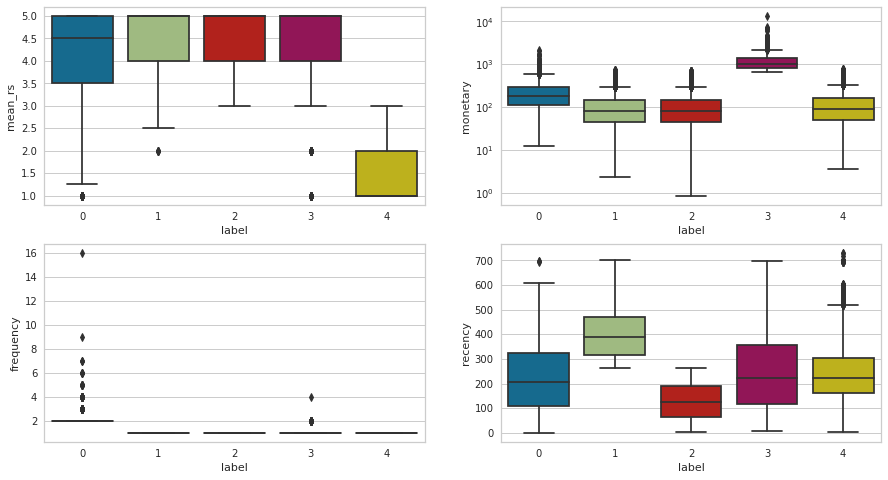

In [90]:
fig3, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.boxplot(ax=ax[0, 0], data=rfm_rs_kmean, x='label', y='mean_rs')
sns.boxplot(ax=ax[0, 1], data=rfm_rs_kmean, x='label', y='monetary')
ax[0, 1].set(yscale='log')
sns.boxplot(ax=ax[1, 0], data=rfm_rs_kmean, x='label', y='frequency')
sns.boxplot(ax=ax[1, 1], data=rfm_rs_kmean, x='label', y='recency')

<AxesSubplot:xlabel='label', ylabel='count'>

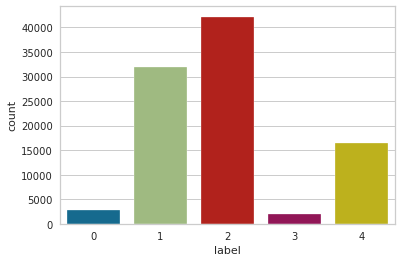

In [91]:
sns.countplot(data=rfm_rs_kmean, x='label')

In [92]:
centroids = pd.DataFrame(clf.cluster_centers_, columns=X.columns).reset_index()
centroids = centroids.rename(columns={'index': 'label'})
scaler = StandardScaler()
norm_rfmrs = pd.DataFrame(scaler.fit_transform(rfm_rs_kmean[['recency',
                                                             'frequency',
                                                             'monetary',
                                                             'mean_rs']]),
                          columns=['recency',
                                   'frequency',
                                   'monetary',
                                   'mean_rs'])
norm_rfmrs['label'] = rfm_rs_kmean.label
# labels_model  = clf.labels_
norm_rfmrs

recency  frequency  monetary   mean_rs  label
0     -0.832472  -0.161045 -0.057615  0.679163      2
1     -0.812885  -0.161045 -0.567596 -0.077543      2
2      1.948932  -0.161045 -0.337415 -0.834249      1
3      0.538643  -0.161045 -0.535021 -0.077543      1
4      0.323182  -0.161045  0.172566  0.679163      1
...         ...        ...       ...       ...    ...
95415  1.361312  -0.161045  6.558813  0.679163      3
95416  0.153425  -0.161045 -0.356298 -0.077543      1
95417  2.151335  -0.161045 -0.241392  0.679163      1
95418 -0.780239  -0.161045 -0.126072  0.679163      2
95419  1.602889  -0.161045 -0.392594  0.679163      1

[95420 rows x 5 columns]

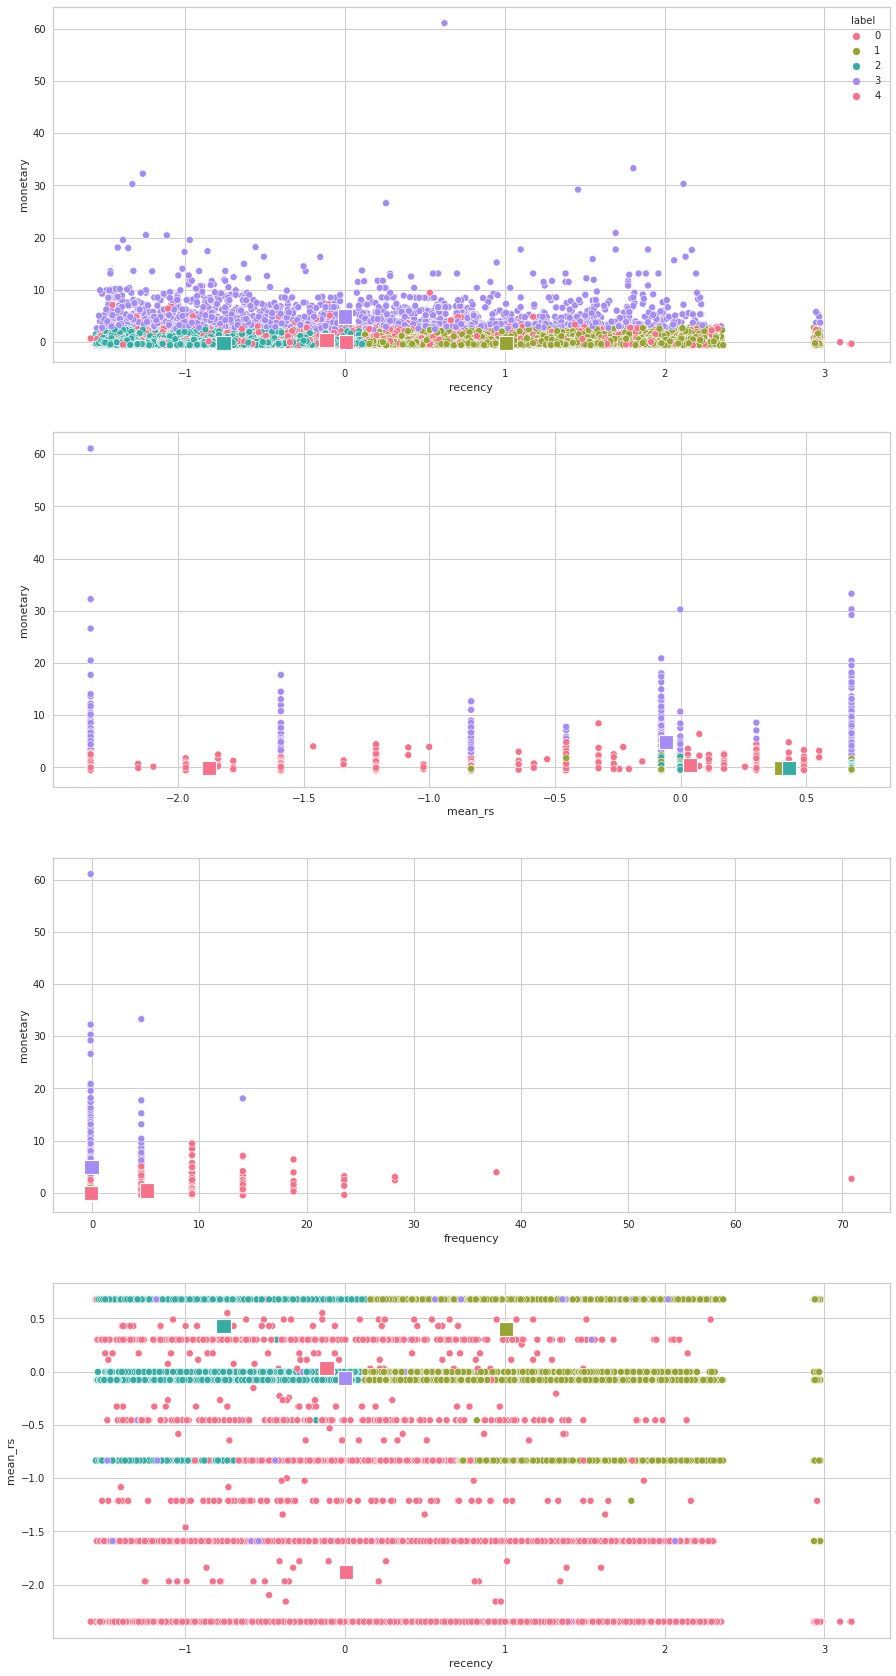

In [93]:
fig4, ax = plt.subplots(4, figsize=(15, 30))
sns.scatterplot(ax=ax[0], data=norm_rfmrs, x='recency',
                y='monetary', hue='label', palette='husl')
sns.scatterplot(ax=ax[0], data=centroids, x='recency',
                y='monetary', hue='label', s=200, markers='s',
                legend=False, marker='s', palette='husl')

sns.scatterplot(ax=ax[1], data=norm_rfmrs, y='monetary',
                x='mean_rs', hue='label', palette='husl', legend=False)
sns.scatterplot(ax=ax[1], data=centroids, x='mean_rs',
                y='monetary', hue='label', s=200,
                legend=False, marker='s', palette='husl')

sns.scatterplot(ax=ax[2], data=norm_rfmrs, x='frequency',
                y='monetary', hue='label', legend=False, palette='husl')
sns.scatterplot(ax=ax[2], data=centroids, x='frequency',
                y='monetary', hue='label', s=200, legend=False,
                marker='s', palette='husl')

sns.scatterplot(ax=ax[3], data=norm_rfmrs, y='mean_rs',
                x='recency', hue='label', legend=False, palette='husl')
sns.scatterplot(ax=ax[3], data=centroids, y='mean_rs',
                x='recency', hue='label', s=200, legend=False,
                marker='s', palette='husl')
plt.show()

Text(0.5, 0, 'Recency')

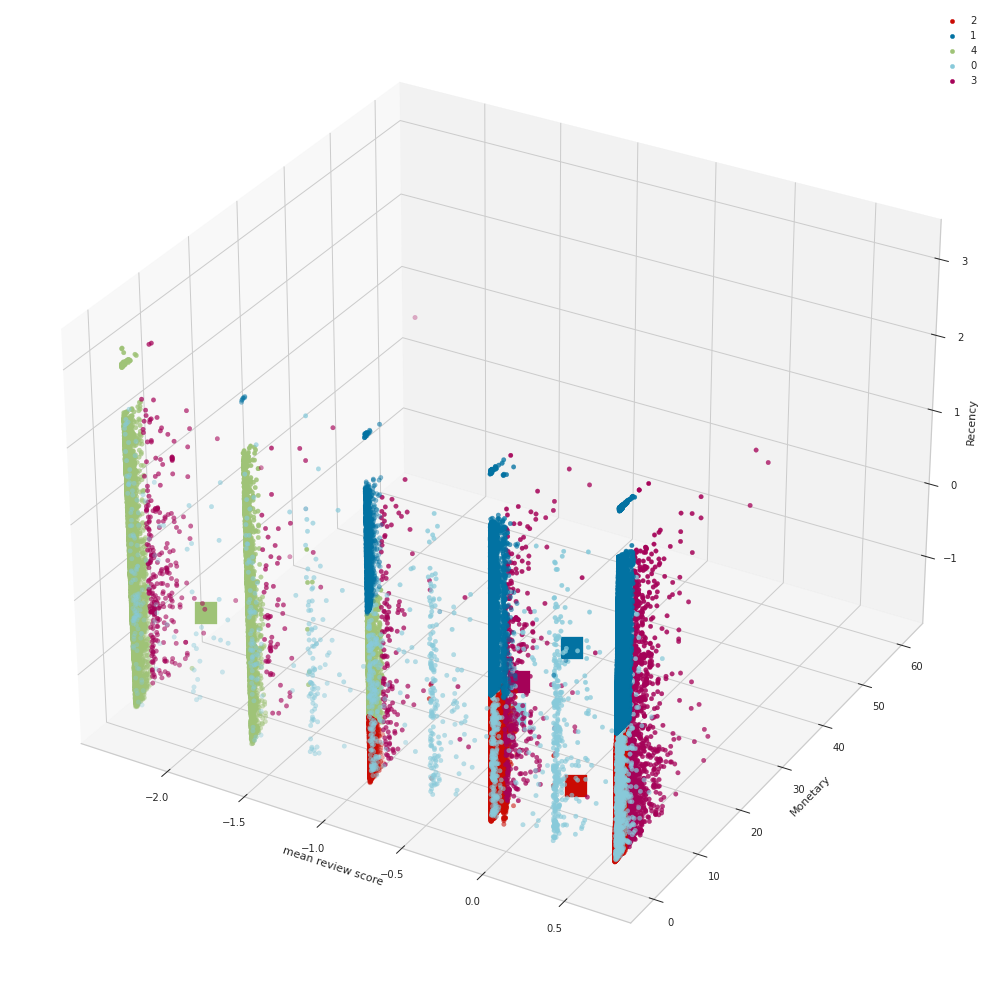

In [94]:
import itertools
fig = plt.figure(figsize=(18, 18))
fig = fig.add_subplot(111, projection='3d')
colors = itertools.cycle(["r", "b", "g", 'c', 'm'])
colors2 = itertools.cycle(["r", "b", "g", 'c', 'm'])

for s in norm_rfmrs.label.unique():
    fig.scatter(norm_rfmrs.mean_rs[norm_rfmrs.label == s],
                norm_rfmrs.monetary[norm_rfmrs.label == s],
                norm_rfmrs.recency[norm_rfmrs.label == s],
                label=s, color=next(colors))

    fig.scatter(centroids.mean_rs[centroids.label == s],
                centroids.monetary[centroids.label == s],
                centroids.recency[centroids.label == s],
                marker='s', s=450, color=next(colors2))

fig.legend()
fig.set_xlabel('mean review score')
fig.set_ylabel('Monetary')
fig.set_zlabel('Recency')

In [95]:
fig = px.scatter_3d(norm_rfmrs, x='monetary', z='frequency', y='recency',
                    color='label')
#fig.show()

3:1: E265 block comment should start with '# '


# Defining strategy to update de model
Work is donne on a K-mean model with 4 features: 
 - recency
 - frequency
 - monetary
 - mean_review score

In [96]:
# First model with all data
data_0 = pd.DataFrame(rfm_rs[['customer_unique_id',
                              'recency',
                              'frequency',
                              'monetary',
                              'mean_rs']])
X_0 = data_0[['recency', 'frequency', 'monetary', 'mean_rs']]

# data_0 - 15 days less
data_1 = pd.DataFrame(data_0[data_0.recency > 15]).reset_index()
X_1 = data_1[['recency', 'frequency', 'monetary', 'mean_rs']]
print('X1', X_1.shape)
# data_0 - 20 days less
data_2 = pd.DataFrame(data_0[data_0.recency > 20]).reset_index()
X_2 = data_2[['recency', 'frequency', 'monetary', 'mean_rs']]
print('X2', X_2.shape)
# data_0 - 30 days less
data_3 = pd.DataFrame(data_0[data_0.recency > 30]).reset_index()
X_3 = data_3[['recency', 'frequency', 'monetary', 'mean_rs']]
print('X3', X_3.shape)
# data_0 - 60 days less
data_4 = pd.DataFrame(data_0[data_0.recency > 60]).reset_index()
X_4 = data_4[['recency', 'frequency', 'monetary', 'mean_rs']]
print('X4', X_4.shape)

X1 (94045, 4)
X2 (92684, 4)
X3 (89928, 4)
X4 (83651, 4)


In [97]:
# model
model_base = KMeans(n_clusters=5, random_state=40,
                    init='k-means++')
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('model', model_base)])

In [98]:
# Model T0 for d0  (all data)
M0 = pipeline.fit(X_0)
data_0['label_M0'] = M0.predict(X_0)

# Model T1 = T0-15days
M1 = pipeline.fit(X_1)
# predict labels for d0 with M1
data_0['label_M1'] = M1.predict(X_0)

# Model T2 = T0-20days
M2 = pipeline.fit(X_2)
# predict labels for d0 with M2
data_0['label_M2'] = M2.predict(X_0)

# Model T3 = T0-30days
M3 = pipeline.fit(X_3)
# predict labels for d0 with M3
data_0['label_M3'] = M3.predict(X_0)

# Model T3 = T0-30days
M4 = pipeline.fit(X_4)
# predict labels for d0 with M3
data_0['label_M4'] = M4.predict(X_0)


In [99]:
from sklearn.metrics.cluster import adjusted_rand_score
ari_00 = adjusted_rand_score(data_0.label_M0, data_0.label_M0)
ari_01 = adjusted_rand_score(data_0.label_M0, data_0.label_M1)
ari_02 = adjusted_rand_score(data_0.label_M0, data_0.label_M2)
ari_03 = adjusted_rand_score(data_0.label_M0, data_0.label_M3)
ari_04 = adjusted_rand_score(data_0.label_M0, data_0.label_M4)
index = [ari_00, ari_01, ari_02, ari_03, ari_04]
days = [0, 15, 20, 30, 60]

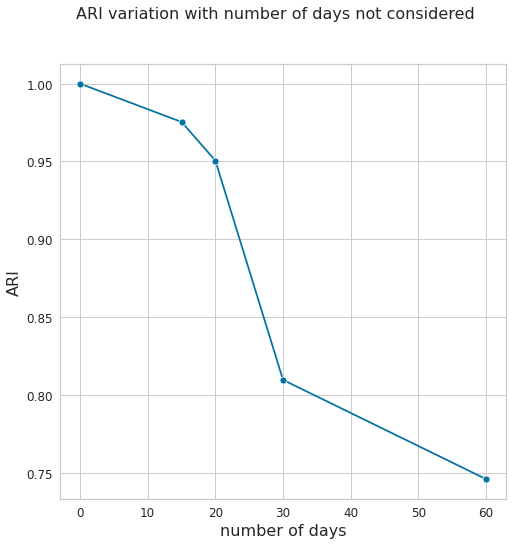

1:35: E231 missing whitespace after ','


In [100]:
fig5, ax = plt.subplots(figsize=(8,8))
sns.lineplot(ax=ax, x=days, y=index, marker='o')
ax.set_ylabel('ARI', fontsize=16)
ax.set_xlabel('number of days', fontsize=16)
fig5.suptitle('ARI variation with number of days not considered', fontsize=16)
ax.tick_params(axis='both', labelsize=12)

<AxesSubplot:xlabel='label_M3', ylabel='count'>

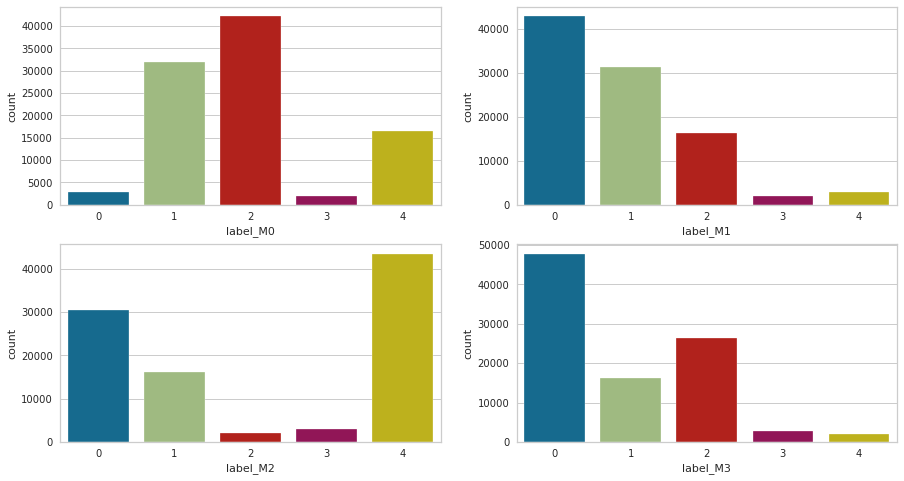

In [101]:
fig6, ax = plt.subplots(2, 2, figsize=(15, 8))

sns.countplot(ax=ax[0, 0], data=data_0, x='label_M0')
sns.countplot(ax=ax[0, 1], data=data_0, x='label_M1')
sns.countplot(ax=ax[1, 0], data=data_0, x='label_M2')
sns.countplot(ax=ax[1, 1], data=data_0, x='label_M3')

# DBSCAN Clustering

Density-Based spatial clustering of Applications with Noise (DBSCAN) 

In [102]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

dbscan_rfm = pd.DataFrame(rfm[['frequency', 'recency', 'monetary']])
X = dbscan_rfm.sample(100)
scaler = MinMaxScaler()
X_trans = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_trans.describe()

## Tuning parameters
- Epsilon
- min_sample

S =[]# this is to store Silhouette scores
comb=[] # this is to store combinations of epsilon / min_samples

# Define ranges to explore
eps_range=range(6,12) # note, we will scale this down by 100 as we want to explore 0.06 - 0.11 range
minpts_range=range(3,8)

for k in eps_range:
    for j in minpts_range:
        # Set the model and its parameters
        model = DBSCAN(eps=k/100, min_samples=j)
        # Fit the model 
        clm = model.fit(X_trans)
        # Calculate Silhoutte Score and append to a list
        S.append(silhouette_score(X_trans, clm.labels_, metric='euclidean'))
        comb.append(str(k)+"|"+str(j)) # axis values for the graph

plt.figure(figsize=(16,8), dpi=300)
plt.plot(comb, S, 'bo-', color='black')
plt.xlabel('Epsilon/100 | MinPts')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score based on different combination of Hyperparameters')
plt.show()